In [1]:
import os

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch.optim import Adam

from pathlib import Path
import LocalLearning_copy as LocalLearning
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.optimize import curve_fit 

# 

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# Hyper parameters:
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000
LEARNING_RATE = 1e-4

# loss function
ce_loss = torch.nn.CrossEntropyLoss()

In [4]:
cifar10Train= LocalLearning.LpUnitCIFAR10(
            root="../data/CIFAR10",
            train=True,
            transform=ToTensor(),
            p=3.0,
        )

cifar10Test= LocalLearning.LpUnitCIFAR10(
            root="../data/CIFAR10",
            train=False,
            transform=ToTensor(),
            p=3.0,
        )

TestLoader = LocalLearning.DeviceDataLoader(
            cifar10Test,
            device=device,
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )

TrainLoader = LocalLearning.DeviceDataLoader(
            cifar10Train,
            device=device,
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )

Files already downloaded and verified
Files already downloaded and verified


In [5]:
scales_stringer_spectra = np.array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [6]:
def load_trained_model_bp(idx):
    trained_model_bp_path = Path("../data/models/KHModelCIFAR10_ensemble/bp")
    file_names_trained_bp = os.listdir(trained_model_bp_path)
    file_names_trained_bp = [fn for fn in file_names_trained_bp if os.path.isfile(trained_model_bp_path / Path(fn))]
    
    trained_model_bp = Path(file_names_trained_bp[idx])
    
    with torch.no_grad():
        trained_state_bp = torch.load(trained_model_bp_path/trained_model_bp)
        model_ps_bp = trained_state_bp["fkhl3-state"]
        model_bp = LocalLearning.KHModel_bp(model_ps_bp)
        model_bp.eval()
        model_bp.load_state_dict(trained_state_bp["model_state_dict"])
        model_bp.to(device)
        
    return model_bp

def load_trained_model_ll(idx):
        
    trained_model_ll_path = Path("../data/models/KHModelCIFAR10_ensemble/ll")
    file_names_trained_ll = os.listdir(trained_model_ll_path)
    file_names_trained_ll = [fn for fn in file_names_trained_ll if os.path.isfile(trained_model_ll_path / Path(fn))]
    
    trained_model_ll = Path(file_names_trained_ll[idx])
    
    with torch.no_grad():
        trained_state_ll = torch.load(trained_model_ll_path/trained_model_ll)
        model_ps_ll = trained_state_ll["fkhl3-state"]
        model_ll = LocalLearning.KHModel(model_ps_ll)
        model_ll.eval()
        model_ll.load_state_dict(trained_state_ll["model_state_dict"])
        model_ll.to(device)
        
    return model_ll

In [7]:
"""
fkhl3-path": str(llmodels_path / model_file),
"fkhl3-state": ll_trained_state,
"model_state_dict": khmodel.state_dict(),
"loss_history": loss_history,
"accuracy_history": accuracy_history
""" 
print()

In [8]:
def acc_total(
    test: DataLoader,
    model: LocalLearning.KHModel, 
    thres,
    crit=None
    ):
    
    freq_correct = 0
    model.eval()
    total = 0
    for batch_no, (features, labels) in enumerate(test):
        preds = model(features)
        pred = torch.argmax(preds, dim=-1)
        
        if crit == "correct_thres":
            softmax_correct = (preds[torch.arange(1000),pred])
            thres_idx = (softmax_correct >= thres)
            correct_idx = (torch.abs(pred - labels) == 0)
            filtr_idx = thres_idx & correct_idx 
            new_preds = pred[filtr_idx]
            new_labels = labels[filtr_idx]
            total += len(new_labels)
            
        elif crit == "thres":
            softmax_correct = (preds[torch.arange(1000),pred])
            thres_idx = (softmax_correct >= thres)
            new_preds = pred[thres_idx]
            new_labels = labels[thres_idx]
            total += len(new_labels)
            
        elif crit == "correct": 
            correct_idx = (torch.abs(pred - labels) == 0)
            new_preds = pred[correct_idx]
            new_labels = labels[correct_idx]
            total += len(new_labels)
            
        elif crit == None:
            new_preds = torch.argmax(preds,axis=1)
            new_labels = labels
            total += len(new_labels)
        
        freq_correct += (torch.abs(new_preds - new_labels) == 0).sum()
        
    correct = (freq_correct / total).item()
    
    return correct, total

In [9]:
def acc_total_n_models(n,modeltype,dataloader,thres,crit=None):
    list_acc = []
    list_n = []
    
    if modeltype == "bp": 
        for i in tqdm(range(n)):
            model = load_trained_model_bp(i)
            correct, total = acc_total(dataloader, model, thres, crit)
            list_acc.append(correct)
            list_n.append(total)
        
    if modeltype == "ll": 
        for i in tqdm(range(n)):
            model = load_trained_model_ll(i)
            correct, total = acc_total(dataloader, model, thres, crit)
            list_acc.append(correct)
            list_n.append(total)
        
    return list_acc, list_n 

In [10]:
n = 100
dataloader = TestLoader
threshold = 0.8

In [11]:
#list_acc_normal, list_n_normal = acc_total_n_models(100,"bp",dataloader,0)
#torch.save(list_acc_normal,"../data/Mia_data/accuracy_all_bp_models.pt")

In [12]:
def print_info(n, model, dataloader, threshold, crit):
    acc, tot = acc_total(n, model, dataloader, threshold, crit)
    if crit == "correct_thres":
        print(f"Criterium = Correct and above 0.8")
        
    elif crit == "thres":
        print(f"Criterium = Above 0.8")

    else: 
        print(f"Criterium = Correct")
        
    print(f"Mean correct for {n} {model} models with Softmax >= {threshold} on training data : {np.mean(acc)*100:.2f} %")
    print(f"Mean number of pictures = {np.mean(tot)}")

In [13]:
for model in ["bp", "ll"]:
    for crit in ["correct_thres", "correct", "thres"]:
        pass

Choosing correct and over threshold as the critirium and the TestLoader as the data set 

In [14]:
def data_critirium(
    dataloader,
    model, 
    crit,
    thres = None
    ):
    
    # Returns the data that meets the critirium given (crit)
    
    freq_correct = 0
    model.eval()
    total = 0
    
    data = torch.zeros((0,32,32,3)).to(device)
    lab_data = torch.zeros((0)).to(device)
    
    for batch_no, (features, labels) in enumerate(dataloader):
        preds = model(features)
        pred = torch.argmax(preds, dim=-1)
        
        if crit == "correct":
            filtr_idx = (torch.abs(pred - labels) == 0)
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
        
        elif crit == "correct_thres":
            softmax_correct = (preds[torch.arange(1000),pred])
            thres_idx = (softmax_correct >= thres)
            correct_idx = (torch.abs(pred - labels) == 0)
            filtr_idx = thres_idx & correct_idx 
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
            
        else:
            softmax_correct = (preds[torch.arange(1000),pred])
            filtr_idx = (softmax_correct >= thres)
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
    
    return data, lab_data

In [15]:
def FGSM(model, features, labels, loss_fn, optimizer, epsilon):
    
    preds = model(features)
    loss = loss_fn(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    perturbed_image = features + epsilon*features.grad.data.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

# implement PGD

In [16]:
def test_attack(
    features,
    labels, 
    model, 
    attack,
    loss_fn, 
    optimizer, 
    eps=None,
    std=None,
    ):
    
    freq_correct = 0
    total = 0 

    labels = labels.type(torch.LongTensor).to(device)
    features.requires_grad = True
    
    if attack == "FGSM":
        perturbed = FGSM(model, features, labels, loss_fn, optimizer, eps)
        
    elif attack == "PGD":
        perturbed, epsilon = PGD(model, features, labels, loss_fn, optimizer, num_steps=20, step_size=0.01, b_norm=0.3)
        
    else: 
        print("Something went wrong")
        
    preds_perturbed = torch.argmax(model(perturbed), dim=-1)
    alike = (preds_perturbed == labels)
    freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
    total += len(labels)

    correct = (freq_correct/total).item()
    
    return correct, alike, epsilon 

In [17]:
epslist = [0.0001*i for i in range(1,100)]

def logistic(x,a,b,c,d):
    return a/(1+np.exp(-c*(x-d)))+b

def criteps_FGSM(n,modeltype,attacktype="FGSM",plot=False,crit=None, epslist=epslist):
    
    if modeltype == "ll":
    
        ll = []
        ll_crit_eps = []
        ll_eps_half_max = []

        for i in tqdm(range(n)):
            model_ll = load_trained_model_ll(i)
            data_ll, lab_ll = data_critirium(TestLoader, model_ll, "correct_thres", thres = 0.8)

            AdamOpt_ll = Adam(model_ll.parameters(), lr=LEARNING_RATE)

            list_ll = []

            for eps in epslist:
                correct, a, e = test_attack(data_ll, lab_ll, model_ll, attacktype, ce_loss, AdamOpt_ll, eps)
                list_ll.append(float(correct))

            ll.append(list_ll)

            x = np.array(epslist)
            y_ll = np.array(list_ll)

            popt, pcov = curve_fit(logistic, x, y_ll)
            critical_eps = popt[-1]

            ll_crit_eps.append(critical_eps)

            x_high_res = np.linspace(x[0],x[-1]+1,10000)
            func = logistic(x_high_res,*popt)
            half_max_idx = (np.abs(func-0.5)).argmin()
            eps_half_max = x_high_res[half_max_idx]

            ll_eps_half_max.append(eps_half_max)
        
        
            if plot==True and i == 0:
                plt.plot(x,y_ll)
                plt.plot(x,logistic(x,*popt))
                plt.plot(critical_eps,logistic(critical_eps,*popt),"ro",label="Inflection point of fitted curve")
                plt.plot(eps_half_max,func[half_max_idx],"bo",label="Fitted curve = 0.5")
                plt.title("FGSM on LL model")
                plt.legend()
                plt.show()
        
                
        return ll, ll_crit_eps, ll_eps_half_max
    
    elif modeltype == "bp":
    
        bp = []
        bp_eps_half_max = []

        for i in tqdm(range(n)):
            model_bp = load_trained_model_bp(i)
            data_bp, lab_bp = data_critirium(TestLoader, model_bp, correct_thres, thres = 0.8)

            AdamOpt_bp = Adam(model_bp.parameters(), lr=LEARNING_RATE)

            list_bp = []

            for eps in epslist:
                correct, a, e = test_attack(data_bp, lab_bp, model_bp, attacktype, ce_loss, AdamOpt_bp, eps)
                list_bp.append(correct)

            bp.append(list_bp)

            x = np.array(epslist)
            y_bp = np.array(list_bp)

            popt, pcov = curve_fit(logistic, x, y_bp, p0=(1,0,1,0), maxfev = 10000)
           
            x_high_res = np.linspace(x[0],x[-1]+1,10000)
            func = logistic(x_high_res,*popt)
            half_max_idx = (np.abs(func-0.5)).argmin()
            eps_half_max = x_high_res[half_max_idx]

            bp_eps_half_max.append(eps_half_max)
            
            if plot==True and i == 0:
                plt.plot(x,y_bp)
                plt.plot(x,logistic(x,*popt))
                #plt.plot(critical_eps,logistic(critical_eps,*popt),"ro",label="Inflection point of fitted curve")
                plt.plot(eps_half_max,func[half_max_idx],"bo",label="Fitted curve = 0.5")
                plt.title("FGSM on LL model")
                plt.legend()
                plt.show()
                
        return bp, "Not defined", bp_eps_half_max

In [18]:
def criteps_PGD(n,modeltype,attacktype="PGD",plot=False,crit=None, epslist=epslist):
    
    # This is currently beeing replaced/rewritten further down 
    
    if modeltype == "ll":
    
        ll = [] # number of correct
        ll_crit_eps = []
        ll_eps_half_max = []

        # alle modeller: n = 100
        for i in tqdm(range(n)):
            model_ll = load_trained_model_ll(i)
            data_ll, lab_ll = data_critirium(TestLoader, model_ll, "correct_thres", thres = 0.8)

            AdamOpt_ll = Adam(model_ll.parameters(), lr=LEARNING_RATE)

            eps = 1 # workaround for now, must fix function test_attack to fit PGD
            correct, epsilon = test_attack(data_ll, lab_ll, model_ll, attacktype, ce_loss, AdamOpt_ll, eps)
            ll.append(float(correct))
            ll_crit_eps.append(epsilon)
            
    
        return ll, ll_crit_eps, ll_eps_half_max
    
    elif modeltype == "bp":
    
        pass 

In [19]:
accuracy, critical_eps, eps_half_max = criteps_PGD(n = 100, modeltype = "ll")

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'PGD' is not defined

In [ ]:
#torch.save(ll,"../data/Mia_data/accuracy_through_FGSM_all_ll_models.pt")

In [ ]:
poptt = [5.61523970e+04,  5.74443460e-04, -9.22749104e+02, -1.18282523e-02]
xarray = np.linspace(-5,5,10000)
plt.plot(xarray,logistic(xarray,*poptt))
critical_eps = -1.18282523e-02
plt.plot(critical_eps,logistic(critical_eps,*poptt),"ro")
plt.xlim(-0.03,0.01)
plt.show()

# In attempting to define the critical epsilon as the inflection point this happens

In [ ]:
#torch.save(bp,"../data/Mia_data/accuracy_through_FGSM_all_bp_models.pt")

In [ ]:
plt.plot(bp[0])
print(bpeps)

In [ ]:
#torch.save(lleps,"../data/Mia_data/critical_epsilons_ll_models.pt")

In [ ]:
crit_eps_ll = np.array(torch.load("../data/Mia_data/critical_epsilons_ll_models.pt"))
acc_ll = np.array(torch.load("../data/Mia_data/accuracy_all_ll_models.pt"))

acc_bp = np.array(torch.load("../data/Mia_data/accuracy_all_bp_models.pt"))

In [ ]:
print(crit_eps_ll)

In [ ]:
crit_eps_ll_spectra = crit_eps_ll[scales_stringer_spectra]
acc_ll_spectra = acc_ll[scales_stringer_spectra]

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(crit_eps_ll,acc_ll)
plt.scatter(crit_eps_ll_spectra,acc_ll_spectra,c="red")
plt.xlabel("Critical epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
eps_fit_curve_at_half_ll = torch.load("../data/Mia_data/epsilon_fitted_curve_at_05_all_ll_models.pt")
eps_fit_curve_at_half_bp = torch.load("../data/Mia_data/epsilon_fitted_curve_at_05_all_bp_models.pt")

In [ ]:
print(np.mean(eps_fit_curve_at_half_ll))
print(np.mean(eps_fit_curve_at_half_bp))

In [20]:
def crit_eps_one_model(modeltype,n,attack,epslist=epslist):
    
    #n = modelnumber
    
    if modeltype == "ll":
    
        ll_crit_eps = []
        list_ll_correct_all = []

        model_ll = load_trained_model_ll(n)
        data_ll, lab_ll = data_critirium(TestLoader, model_ll, "correct")#, thres = 0.8)
        
        siz = len(lab_ll)
        
        crit_eps_per_image = torch.ones(siz).to(device)
        crit_eps_per_image[:] = epslist[-1]
        
        AdamOpt_ll = Adam(model_ll.parameters(), lr=LEARNING_RATE)

        for eps in epslist:
            correct, alike = test_attack(data_ll, lab_ll, model_ll, attack, ce_loss, AdamOpt_ll, eps)
            mask = (alike == False) & (crit_eps_per_image == epslist[-1])
            crit_eps_per_image[mask] = eps
            list_ll_correct_all.append(correct)

        x = np.array(epslist)
        y_ll = np.array(list_ll_correct_all)

        popt, pcov = curve_fit(logistic, x, y_ll)
        critical_eps = popt[-1]

        ll_crit_eps.append(critical_eps)
                        
        return crit_eps_per_image #, list_ll_correct_all, ll_crit_eps
    
    if modeltype == "bp":
    
        bp_crit_eps = []
        list_bp_correct_all = []

        model_bp = load_trained_model_bp(n)
        data_bp, lab_bp = data_critirium(TestLoader, model_bp, "correct")#, thres = 0.8)
        
        siz = len(lab_bp)
        
        crit_eps_per_image = torch.ones(siz).to(device)
        crit_eps_per_image[:] = epslist[-1]
        
        AdamOpt_bp = Adam(model_bp.parameters(), lr=LEARNING_RATE)

        for eps in epslist:
            correct, alike = test_attack(data_bp, lab_bp, model_bp, attack, ce_loss, AdamOpt_bp, eps)
            mask = (alike == False) & (crit_eps_per_image == epslist[-1])
            crit_eps_per_image[mask] = eps
            list_bp_correct_all.append(correct)

        x = np.array(epslist)
        y_bp = np.array(list_bp_correct_all)

        popt, pcov = curve_fit(logistic, x, y_bp)
        critical_eps = popt[-1]

        bp_crit_eps.append(critical_eps)
        
        return crit_eps_per_image #, list_bp_correct_all, bp_crit_eps

In [21]:
def PGD(model, features, labels, loss_fn, optimizer, num_steps=20, step_size=0.01, b_norm=0.3):
    
    for n in range(num_steps):
        preds = model(features)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        
        adv_image = features + step_size*features.grad.data.sign()
        clamp = torch.clamp(adv_image - features, min = -b_norm, max = b_norm)
        perturbed_image = torch.clamp(features + clamp, min = 0, max = 1)
        
        preds_perturbed = torch.argmax(model(perturbed_image), dim=-1)
        alike = (preds_perturbed == labels)
        freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
        total += len(labels)

        correct = (freq_correct/total).item()

        mask = (alike == False) & (crit_eps_per_image == epslist[-1])
        crit_eps_per_image[mask] = epsilon[mask]
        
    #x = features.view(features.size(0),-1)
    #y = perturbed_image.view(perturbed_image.size(0),-1)
    
    #eps = torch.abs(torch.mean(x-y,dim=1)).detach()
    
    return perturbed_image, eps

In [176]:
def crit_eps_one_image_pgd(modeltype,n):
    
    attack = "PGD"
    
    if modeltype == "ll":
    
        ll_crit_eps = []
        list_ll_correct_all = []

        model = load_trained_model_ll(n)
        features, labels = data_critirium(TestLoader, model, "correct")
        
        siz = len(labels)
        
        crit_eps_per_image = torch.ones(siz).to(device)
        crit_eps_per_image[:] = epslist[-1]
        
        AdamOpt_ll = Adam(model.parameters(), lr=LEARNING_RATE)
        
        freq_correct = 0
        total = 0 

        labels = labels.type(torch.LongTensor).to(device)
        features.requires_grad = True
        
        num_steps = 100
        loss_fn = ce_loss 
        optimizer = AdamOpt_ll
        step_size = 0.0005
        b_norm = 0.05
        
        correct = []
                
        perturbed_image = features 
        
        for n in range(num_steps):
            preds = model(features)
            loss = loss_fn(preds, labels)
            optimizer.zero_grad()
            loss.backward()

            adv_image = perturbed_image + step_size*features.grad.data.sign()
            clamp = torch.clamp(adv_image - features, min = -b_norm, max = b_norm)
            perturbed_image = torch.clamp(features + clamp, min = 0, max = 1)

            preds_perturbed = torch.argmax(model(perturbed_image), dim=-1)
            alike = (preds_perturbed == labels)
            freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
            total += len(labels)

            correct.append((freq_correct/total).item())

            mask = (alike == False) & (crit_eps_per_image == epslist[-1])
            
            x = features.view(features.size(0),-1)
            y = perturbed_image.view(perturbed_image.size(0),-1)
    
            eps = torch.abs(torch.mean(x-y,dim=1)).detach()
            crit_eps_per_image[mask] = eps[mask]

        #perturbed, epsilon = PGD(model, features, labels, ce_loss, AdamOpt_ll, num_steps=20, step_size=0.01, b_norm=0.3)
                        
        return crit_eps_per_image, correct
    
    elif modeltype == "bp":
    
        pass 

In [177]:
crit_eps_per_image, correct = crit_eps_one_image_pgd(modeltype = "ll", n = 1)

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 23.70 GiB total capacity; 20.29 GiB already allocated; 13.81 MiB free; 20.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [178]:
print((crit_eps_per_image==0.0099).sum())
print((crit_eps_per_image!=0.0099).sum())

tensor(1, device='cuda:0')
tensor(3889, device='cuda:0')


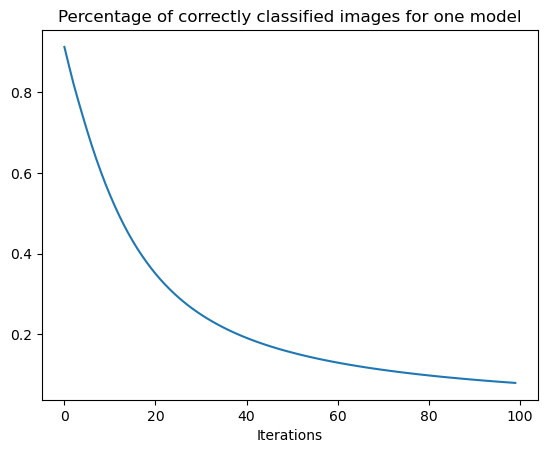

In [190]:
plt.plot(correct)
plt.title("Percentage of correctly classified images for one model")
plt.xlabel("Iterations")
plt.show()
# all are classified corretly from start
# once it is misclassified, it remains so 

In [185]:
all_models_per_image_ll = []
for n in tqdm(range(100)):
    crit_eps_per, correct = crit_eps_one_image_pgd(modeltype = "ll", n = 1)
    all_models_per_image_ll.append(np.array(crit_eps_per.cpu()))

  0%|          | 0/100 [00:00<?, ?it/s]

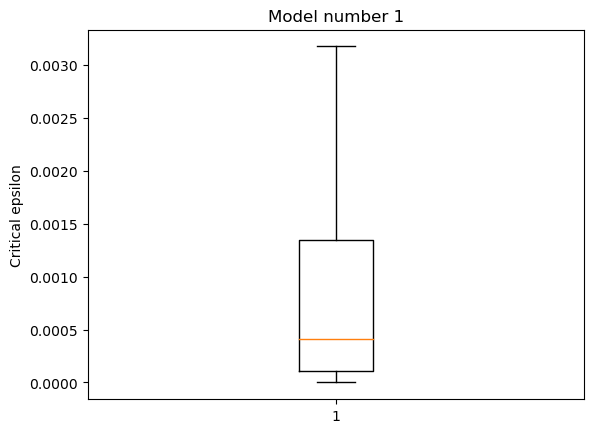

In [192]:
plt.boxplot([all_models_per_image_ll[1]], showfliers=False)
#plt.xticks([1,2],["BP","LL"])
plt.ylabel("Critical epsilon")
plt.title(f"Model number {1}")
plt.show()

In [ ]:
all_models_per_image_bp = []
for n in tqdm(range(100)):
    crit_eps_per = crit_eps_one_model("bp",n,FGSM)
    all_models_per_image_bp.append(np.array(crit_eps_per.cpu()))

In [ ]:
all_models_per_image_ll_pgd = []
for n in tqdm(range(100)):
    crit_eps_per = crit_eps_one_model("ll",n,PGD)
    all_models_per_image_ll_pgd.append(np.array(crit_eps_per.cpu()))

In [ ]:
all_models_per_image_bp_pgd = []
for n in tqdm(range(100)):
    crit_eps_per = crit_eps_one_model("bp",n,PGD)
    all_models_per_image_bp_pgd.append(np.array(crit_eps_per.cpu()))

In [ ]:
long_epslist = [0.0001*i for i in range(1,100)]
crit_eps_bp = crit_eps_one_model("bp",n,FGSM,long_epslist)
crit_eps_ll = crit_eps_one_model("ll",n,FGSM,long_epslist)

In [ ]:
last_eps = long_epslist[-1]
corr = (howlong_ll==last_eps)
print(torch.sum(corr))

In [ ]:
n = 1
plt.boxplot([all_models_per_image_bp[n],all_models_per_image_ll[n]])
plt.xticks([1,2],["BP","LL"])
plt.ylabel("Critical epsilon")
plt.title(f"Model number {n}")
plt.show()

In [187]:
flat_ll = [item for sublist in all_models_per_image_ll for item in sublist]
flat_bp = [item for sublist in all_models_per_image_bp for item in sublist]

boxplotfgsm = plt.boxplot([flat_bp,flat_ll])#,showfliers=False)
plt.xticks([1,2],["All bp models","All ll models"])
plt.ylabel("Critical epsilon")
plt.title("Epsilons for misclassification for FGSM")
plt.show()

meds = [item.get_ydata() for item in boxplotfgsm["medians"]]
print(meds)

NameError: name 'all_models_per_image_bp' is not defined

In [ ]:
#bp_spectra = all_models_per_image_bp[scales_stringer_spectra]

x = scales_stringer_spectra
y = all_models_per_image_bp
stringer_bp = [b for a, b in zip(x, y) if a]
not_stringer_bp = [b for a, b in zip(x, y) if not a]
y = all_models_per_image_ll
stringer_ll = [b for a, b in zip(x, y) if a]
not_stringer_ll = [b for a, b in zip(x, y) if not a]

In [ ]:
flat_ll_stringer = [item for sublist in stringer_ll for item in sublist]
flat_ll_not_stringer = [item for sublist in not_stringer_ll for item in sublist]

boxplot = plt.boxplot([flat_ll_stringer,flat_ll_not_stringer],showfliers=False)
plt.xticks([1,2],["Spectrum = TRUE","Spectrum = FALSE"])
plt.ylabel("Critical epsilon")
plt.title("Epsilons for misclassification for FGSM on ll models")
plt.show()

meds = [item.get_ydata() for item in boxplot["medians"]]
print(meds)
print((meds[0]==meds[1]).all())

In [186]:
flat_bp_stringer = [item for sublist in stringer_bp for item in sublist]
flat_bp_not_stringer = [item for sublist in not_stringer_bp for item in sublist]

plt.boxplot([flat_bp_stringer,flat_bp_not_stringer],showfliers=False)
plt.xticks([1,2],["Spectrum = TRUE","Spectrum = FALSE"])
plt.ylabel("Critical epsilon")
plt.title("Epsilons for misclassification for FGSM on bp models")
plt.show()

meds = [item.get_ydata() for item in boxplot["medians"]]
print((meds[0]==meds[1]).all())

NameError: name 'stringer_bp' is not defined

In [ ]:
flat_ll_pgd = [item for sublist in all_models_per_image_ll_pgd for item in sublist]
flat_bp_pgd = [item for sublist in all_models_per_image_bp_pgd for item in sublist]
boxp = plt.boxplot([flat_bp_pgd,flat_ll_pgd])#,showfliers=False)
plt.xticks([1,2],["All bp models","All ll models"])
plt.ylabel("Critical epsilon")
plt.title("Epsilons for misclassification for PGD")
plt.show()

meds = [item.get_ydata() for item in boxp["medians"]]
print(meds)